In [141]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from astropy.io import fits
import os
import healpy as hp

import plotting
import auxil_ML as aux
import healpylib3 as hlib




In [142]:
plotting.setup_figure_pars()

0

In [143]:
if 0:
    import importlib
    importlib.reload(plotting);
    importlib.reload(aux);
    importlib.reload(hlib);

In [144]:
def min_max_vs(dct, corr={}):
    vals = np.array([dct[key] - corr.get(key, 0.) for key in dct.keys()])
    return np.min(vals, axis=0), np.max(vals, axis=0)

def plot_mollview(fmap, title='', fig=None, vmin=None, vmax=None, **kwargs):
    hp.mollview(fmap, title=title, fig=fig, cbar=None, min=vmin, max=vmax) #cmap=r'afmhot_r'
    #plotting.add_mollview_colorbar(pix_map, label='', nticks=5, ticks=None, tick_labels=None)
    plotting.add_mollview_colorbar(fmap, vmin=vmin, vmax=vmax, **kwargs)
    dpar = 30
    dmer = 30
    grat = hp.graticule(dpar=dpar, dmer=dmer, ls=':')


In [327]:
cat = '3FGL'
folder = '../ML_3FGL_paper/SOM'
cat_fn = '%s/%s_prob_catalog.csv' % (folder, cat)
cat_df = pd.read_csv(cat_fn, index_col=0)
labels = ['AGN', 'PSR', 'MIXED']
plots_folder = 'plots/Accuracies'
print(cat_df.columns)

Index(['Ln_Flux_Density', 'Ln_Unc_Energy_Flux100', 'Spectral_Index',
       'Ln_Signif_Curve', 'Ln_Variability_Index', 'HR12', 'HR23', 'HR34',
       'HR45', 'GLAT', 'Category_3FGL', 'CLASS_3FGL', 'Pivot_Energy',
       'Spectrum_Type', 'ASSOC1', 'AGN_BDT', 'PSR_BDT', 'AGN_NN', 'PSR_NN',
       'AGN_LR', 'PSR_LR', 'AGN_RF', 'PSR_RF', 'Times_in_Testing', 'Flags',
       'Category_Prob', 'GLON'],
      dtype='object')


In [328]:
sin_glat = np.abs(np.sin(np.deg2rad(cat_df['GLAT'])))
glat = np.abs(cat_df['GLAT'])

In [329]:
nbins = 10
sin_bins = np.linspace(0, 1, nbins + 1)**1.5
sin_bins_c = (sin_bins[1:] + sin_bins[:-1]) / 2

In [330]:
masks = {}
masks['AGN & PSR'] = (cat_df['Category_%s' % cat] == 'AGN') | (cat_df['Category_%s' % cat] == 'PSR')
masks['AGN'] = (cat_df['Category_%s' % cat] == 'AGN')
masks['PSR'] = (cat_df['Category_%s' % cat] == 'PSR')
masks['UNAS'] = (cat_df['Category_%s' % cat] == 'UNAS')
masks['ASSOC'] = (cat_df['Category_%s' % cat] != 'UNAS')


In [331]:
res = {}
res_prec = {}
nsrc = {}
nsrc_prec = {}
for key in masks.keys():
    res[key] = np.zeros(nbins)
    res_prec[key] = np.zeros(nbins)
    nsrc[key] = np.zeros(nbins)
    nsrc_prec[key] = np.zeros(nbins)

save figure to file: plots/Accuracies/All algs_3FGL.pdf
save figure to file: plots/Accuracies/source_counts_All algs_3FGL.pdf
save figure to file: plots/Accuracies/NN_3FGL.pdf
save figure to file: plots/Accuracies/source_counts_NN_3FGL.pdf
save figure to file: plots/Accuracies/LR_3FGL.pdf
save figure to file: plots/Accuracies/source_counts_LR_3FGL.pdf
save figure to file: plots/Accuracies/RF_3FGL.pdf
save figure to file: plots/Accuracies/source_counts_RF_3FGL.pdf
save figure to file: plots/Accuracies/BDT_3FGL.pdf
save figure to file: plots/Accuracies/source_counts_BDT_3FGL.pdf


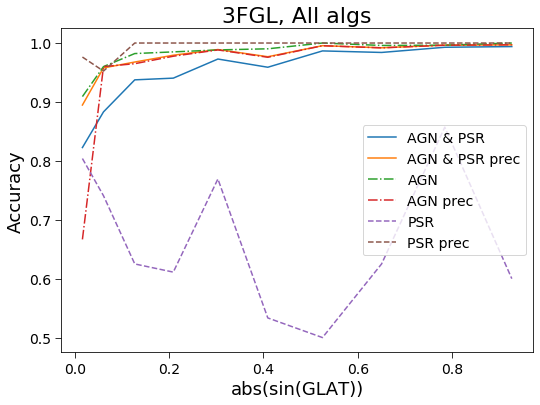

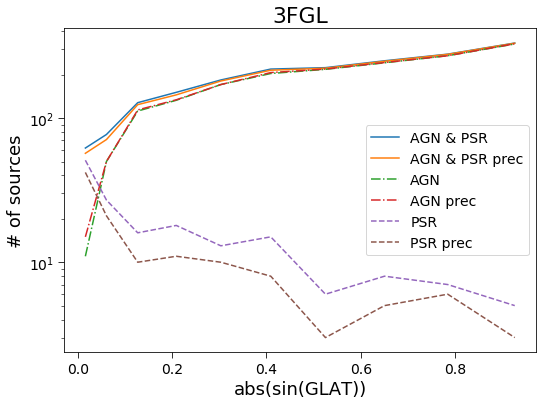

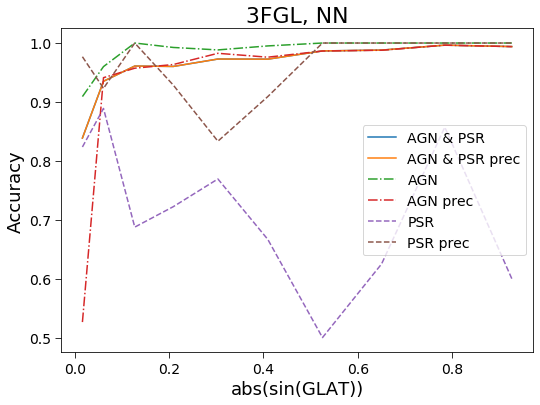

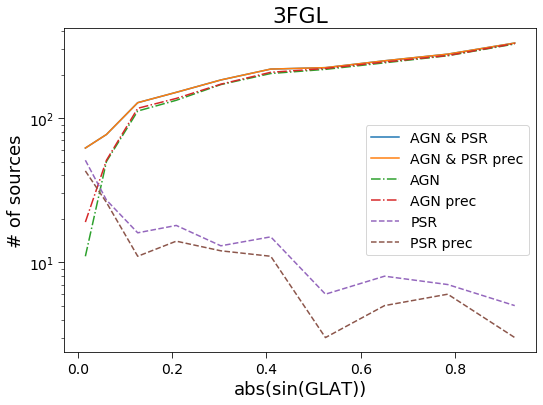

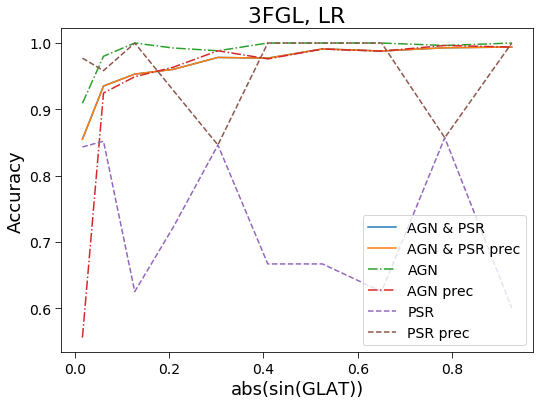

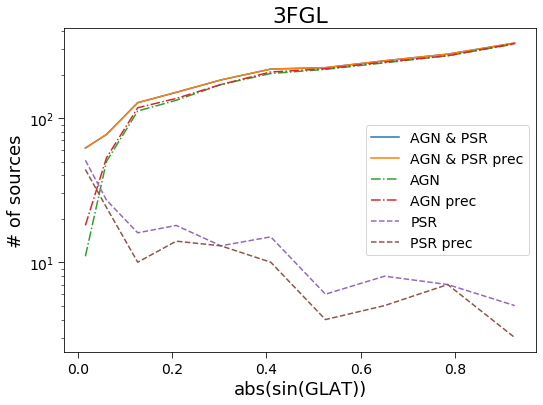

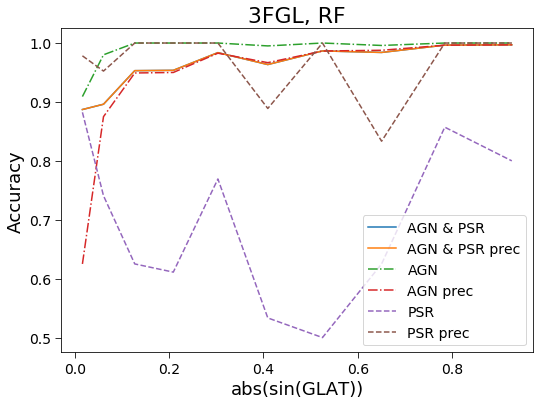

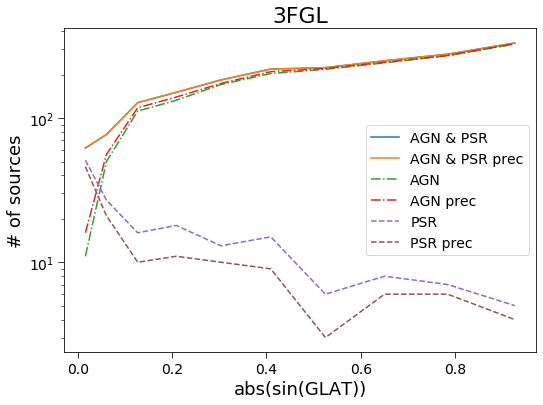

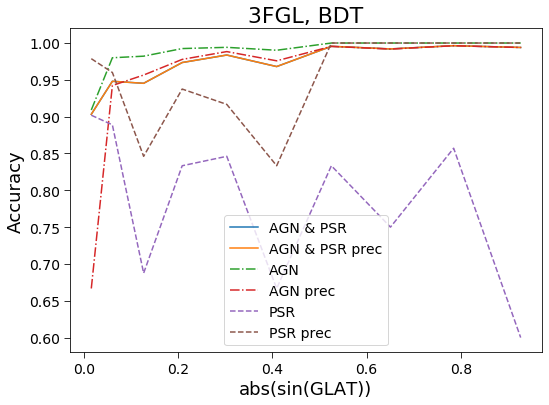

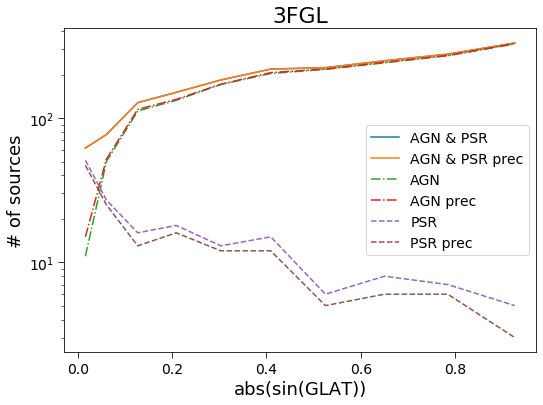

In [332]:
#alg = 'All algs'
algs0 = ['NN', 'LR', 'RF', 'BDT']
algs = ['All algs', 'NN', 'LR', 'RF', 'BDT']
save_plots = True
for alg in algs:
    masks_prec = {}
    if alg == 'All algs':
        masks_prec['AGN & PSR'] = (cat_df['Category_Prob'] == 'AGN') | (cat_df['Category_Prob'] == 'PSR')
        masks_prec['AGN'] = (cat_df['Category_Prob'] == 'AGN')
        masks_prec['PSR'] = (cat_df['Category_Prob'] == 'PSR')
    else:
        masks_prec['AGN & PSR'] = (cat_df['AGN_%s' % alg] > 0.5) | (cat_df['PSR_%s' % alg] > 0.5)
        masks_prec['AGN'] = (cat_df['AGN_%s' % alg] > 0.5)
        masks_prec['PSR'] = (cat_df['PSR_%s' % alg] > 0.5)
        
    for i in range(nbins):
        for key in masks_prec.keys():
            bin_mask = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & masks[key]
            y_true = cat_df['Category_%s' % cat][bin_mask]
            if alg == 'All algs':
                y_pred = cat_df['Category_Prob'][bin_mask]
            else:
                y_pred = y_true.copy()
                y_pred[:] = 'PSR'
                agn_mask = cat_df['AGN_%s' % alg][bin_mask] > 0.5
                y_pred[agn_mask] = 'AGN'
            res[key][i] = accuracy_score(y_true, y_pred)
            nsrc[key][i] = np.sum(bin_mask)
            
            bin_mask = (sin_glat > sin_bins[i]) & (sin_glat <= sin_bins[i + 1]) & masks_prec[key] & masks['AGN & PSR']
            y_true = cat_df['Category_%s' % cat][bin_mask]
            if alg == 'All algs':
                y_pred = cat_df['Category_Prob'][bin_mask]
            else:
                y_pred = y_true.copy()
                y_pred[:] = 'PSR'
                agn_mask = cat_df['AGN_%s' % alg][bin_mask] > 0.5
                y_pred[agn_mask] = 'AGN'
            res_prec[key][i] = accuracy_score(y_true, y_pred)
            nsrc_prec[key][i] = np.sum(bin_mask)
            
    lss = ['-', '-.', '--']
    pyplot.figure()
    for i, key in enumerate(masks_prec.keys()):
        pyplot.plot(sin_bins_c, res[key], ls=lss[i], label=key)
        pyplot.plot(sin_bins_c, res_prec[key], ls=lss[i], label=key + ' prec')
    pyplot.xlabel('abs(sin(GLAT))')
    pyplot.ylabel('Accuracy')
    pyplot.title('%s, %s' % (cat, alg))
    pyplot.legend()

    if save_plots:
        fn = '%s/%s_%s.pdf' % (plots_folder, alg, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)

    pyplot.figure()
    for i, key in enumerate(masks_prec.keys()):
        pyplot.semilogy(sin_bins_c, nsrc[key], ls=lss[i], label=key)
        pyplot.semilogy(sin_bins_c, nsrc_prec[key], ls=lss[i], label=key + ' prec')
    pyplot.xlabel('abs(sin(GLAT))')
    pyplot.ylabel('# of sources')
    pyplot.title('%s' % (cat))
    pyplot.legend()

    if save_plots:
        fn = '%s/source_counts_%s_%s.pdf' % (plots_folder, alg, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)


In [333]:
# GLAT distribution
nbins = 18
sin_bins_unif = np.linspace(0, 1, nbins+1)
sin_bins_unif_c = (sin_bins_unif[1:] + sin_bins_unif[:-1]) / 2.
lat_bins_unif = np.linspace(0, 90, nbins+1)
lat_bins_unif_c = (lat_bins_unif[1:] + lat_bins_unif[:-1]) / 2.
unas_mask = cat_df['Category_%s' % cat] == 'UNAS'

In [334]:
pcat_SP = pd.read_csv('data/FGL3_results.csv', index_col='Source_Name')
pcat_SP.index = ['3FGL %s' %name.strip() for name in pcat_SP.index]
unass_lat_SP = {}
algs0_SP = ['RF', 'LR']
unas_mask_SP = pcat_SP['CLASS1'].copy()
unas_mask_SP[:] = [type(pcat_SP['CLASS1'].iloc[i]) != str for i in range(len(unas_mask_SP))]
sin_glat_SP = np.abs(np.sin(np.deg2rad(pcat_SP['GLAT'])))
glat_SP = np.abs(pcat_SP['GLAT'])
glon_SP = pcat_SP['GLON'] - 360 * (pcat_SP['GLON'] // 180)

In [335]:
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.bottom'])

save figure to file: plots/Accuracies/lat_profile_AGN_3FGL.pdf
cp plots/Accuracies/lat_profile_AGN_3FGL.pdf ../ML_3FGL_paper/plots
save figure to file: plots/Accuracies/lat_profile_PSR_3FGL.pdf
cp plots/Accuracies/lat_profile_PSR_3FGL.pdf ../ML_3FGL_paper/plots


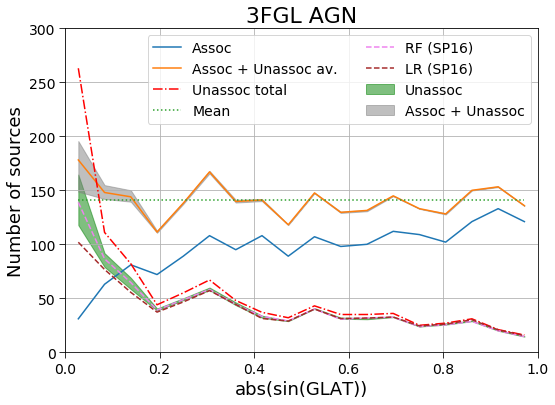

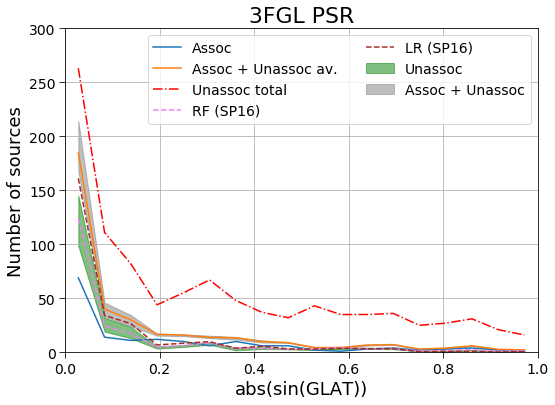

In [336]:
SP_colors = ['violet', 'brown']
use_sin_glat = 1
#plotting.setup_figure_pars()
#print(pyplot.rcParams['figure.subplot.left'])
#pyplot.rcParams['figure.subplot.bottom'] = 0.15
unass_lat_tot = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif)[0]
for pop in ['AGN', 'PSR']:
    ass_lat = np.histogram(sin_glat[masks[pop]], bins=sin_bins_unif)[0]
    unass_lat = {}
    unass_lat_av = np.zeros(nbins)
    for alg in algs0:
        if use_sin_glat:
            unass_lat[alg] = np.histogram(sin_glat[unas_mask], bins=sin_bins_unif, 
                                              weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        else:
            unass_lat[alg] = np.histogram(glat[unas_mask], bins=lat_bins_unif, 
                                              weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
            
        unass_lat_av += unass_lat[alg] / len(algs0)
    
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            if use_sin_glat:
                unass_lat_SP[alg] = np.histogram(sin_glat_SP[unas_mask_SP], bins=sin_bins_unif, 
                                              weights=weights)[0]
            else:
                unass_lat_SP[alg] = np.histogram(glat_SP[unas_mask_SP], bins=lat_bins_unif, 
                                              weights=weights)[0]
                
            
    minvs, maxvs = min_max_vs(unass_lat)
    if use_sin_glat:
        xs = sin_bins_unif_c
    else:
        xs = lat_bins_unif_c
    fig = pyplot.figure()
    pyplot.plot(xs, ass_lat, label='Assoc')
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.5, label='Unassoc')
    if 0:
        for alg in algs0:
            pyplot.plot(xs, unass_lat[alg], ls='--', label=alg)
    
    pyplot.fill_between(xs, ass_lat + minvs, ass_lat + maxvs, color='gray', alpha=0.5, 
                        label='Assoc + Unassoc')
    mean = np.mean(ass_lat + unass_lat_av) * np.ones(nbins)
    pyplot.plot(xs, ass_lat + unass_lat_av, label='Assoc + Unassoc av.')
    #pyplot.errorbar(xs, ass_lat + unass_lat_av, np.sqrt(mean), ls='', marker='s', label='Assoc + Unassoc av.')
    pyplot.plot(xs, unass_lat_tot, ls='-.', color='r', label='Unassoc total')
    

    if pop == 'AGN':
        pyplot.plot(xs, mean, ls=':', label='Mean')
    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lat_SP[alg], ls='--', c=SP_colors[i], 
                        label='%s (SP16)' % alg)


    pyplot.title('%s %s' %(cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    if use_sin_glat:
        pyplot.xlabel('abs(sin(GLAT))')
        pyplot.xlim(0, 1)
        #x_ticks = fig.axes[0].get_xticks()
        #x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
        #fig.axes[0].set_xticks(x_ticks_new)
    else:
        pyplot.xlabel('abs(GLAT)')
        pyplot.xlim(0, 90)
        
    pyplot.ylabel('Number of sources')
    if cat == '3FGL':
        pyplot.ylim(0, 300)
    elif cat == '4FGL':
        pyplot.ylim(0, 400)

    if save_plots:
        fn = '%s/lat_profile_%s_%s.pdf' % (plots_folder, pop, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(cmd)
        os.system(cmd)


In [337]:
x_ticks = fig.axes[0].get_xticks()
x_ticks_new = np.around(np.rad2deg(np.arcsin(x_ticks)))
print(x_ticks, x_ticks_new)

[0.  0.2 0.4 0.6 0.8 1. ] [ 0. 12. 24. 37. 53. 90.]


save figure to file: plots/Accuracies/lon_profile_AGN_3FGL.pdf
cp plots/Accuracies/lon_profile_AGN_3FGL.pdf ../ML_3FGL_paper/plots
save figure to file: plots/Accuracies/lon_profile_PSR_3FGL.pdf
cp plots/Accuracies/lon_profile_PSR_3FGL.pdf ../ML_3FGL_paper/plots


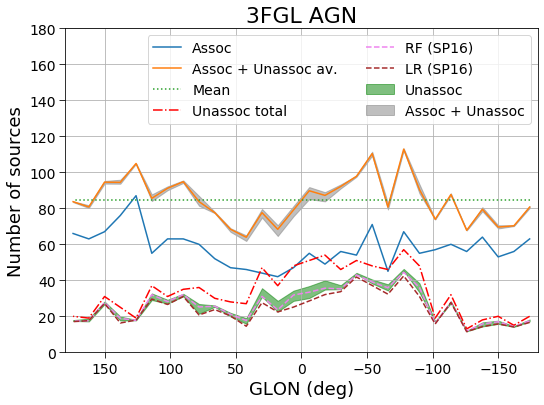

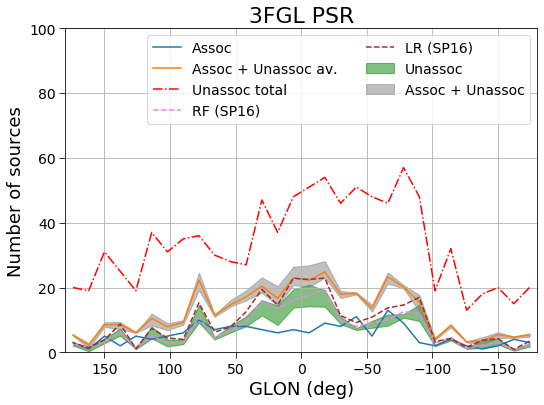

In [338]:
nbins_lon = 30
glon_bins = np.linspace(-180, 180, nbins_lon + 1)
glon_bins_c = (glon_bins[1:] + glon_bins[:-1]) / 2.
# make the range from -180 to 180
glon = cat_df['GLON'] - 360. * (cat_df['GLON'] // 180.)

unass_lon_tot = np.histogram(glon[unas_mask], bins=glon_bins)[0]
for pop in ['AGN', 'PSR']:
    ass_lon = np.histogram(glon[masks[pop]], bins=glon_bins)[0]
    unass_lon = {}
    unass_lon_SP = {}
    unass_lon_av = np.zeros(nbins_lon)
    for alg in algs0:
        unass_lon[alg] = np.histogram(glon[unas_mask], bins=glon_bins, 
                                          weights=cat_df['%s_%s' % (pop, alg)][unas_mask])[0]
        unass_lon_av += unass_lon[alg] / len(algs0)

        
    if cat == '3FGL':
        for alg in algs0_SP:
            if pop == 'PSR':
                weights = pcat_SP['%s_P' % alg][unas_mask_SP]
            elif pop == 'AGN':
                weights = 1 - pcat_SP['%s_P' % alg][unas_mask_SP]
            unass_lon_SP[alg] = np.histogram(glon_SP[unas_mask_SP], bins=glon_bins, 
                                              weights=weights)[0]

    
    minvs, maxvs = min_max_vs(unass_lon)
    xs = glon_bins_c
    pyplot.figure()
    pyplot.plot(xs, ass_lon, label='Assoc')
    pyplot.plot(xs, ass_lon + unass_lon_av, label='Assoc + Unassoc av.')
    if pop == 'AGN':
        mean = np.mean(ass_lon + unass_lon_av) * np.ones(nbins_lon)
        pyplot.plot(xs, mean, ls=':', label='Mean')
    pyplot.plot(xs, unass_lon_tot, ls='-.', color='r', label='Unassoc total')
    pyplot.fill_between(xs, minvs, maxvs, color='green', alpha=0.5, label='Unassoc')
    pyplot.fill_between(xs, ass_lon + minvs, ass_lon + maxvs, color='gray', alpha=0.5, 
                        label='Assoc + Unassoc')

    if 0:
        for alg in algs0:
            pyplot.plot(xs, unass_lon[alg], ls='--', label=alg)
    
    
    if cat == '3FGL':
        for i, alg in enumerate(algs0_SP):
            pyplot.plot(xs, unass_lon_SP[alg], ls='--', c=SP_colors[i], 
                        label='%s (SP16)' % alg)

    pyplot.title('%s %s' % (cat, pop))
    pyplot.legend(ncol=2)
    pyplot.grid()
    pyplot.xlabel('GLON (deg)')
    pyplot.ylabel('Number of sources')
    pyplot.xlim(180, -180)
    if cat == '4FGL':
        if pop == 'AGN':
            pyplot.ylim(0, 250)
        else:
            pyplot.ylim(0, 160)
    else:
        if pop == 'AGN':
            pyplot.ylim(0, 180)
        else:
            pyplot.ylim(0, 100)
        
            
    if save_plots:
        fn = '%s/lon_profile_%s_%s.pdf' % (plots_folder, pop, cat)
        print('save figure to file: %s' % fn)
        pyplot.savefig(fn)
        cmd = 'cp %s ../ML_3FGL_paper/plots' % fn
        print(cmd)
        os.system(cmd)


In [339]:
nside = 64
npix = hp.nside2npix(nside)


In [340]:
# calculate unass pixels
def mask2pixels(mask):
    phi = np.deg2rad(cat_df['GLON'][mask])
    theta = np.pi/2 - np.deg2rad(cat_df['GLAT'][mask])
    return list(hp.ang2pix(nside, theta, phi))

pix_dict = {}
for pop in ['AGN', 'PSR', 'UNAS']:
    pix_dict[pop] = mask2pixels(masks[pop])


In [341]:
alg = 'NN'
hpm_dict_ass = {}
hpm_dict_unass = {}
sigma = np.radians(10.)
for pop in ['AGN', 'PSR']:
    # associated sources
    hpm_dict_ass[pop] = np.zeros(npix)
    for i, ind in enumerate(pix_dict[pop]):
        hpm_dict_ass[pop][ind] += 1
    hpm_dict_ass[pop + '_sm'] = hp.smoothing(hpm_dict_ass[pop], sigma=sigma)
        
    # probabilities for unassociated sources
    probs = cat_df['%s_%s' % (pop, alg)][masks['UNAS']]
    hpm_dict_unass[pop] = np.zeros(npix)
    for i, ind in enumerate(pix_dict['UNAS']):
        hpm_dict_unass[pop][ind] += probs[i]
    hpm_dict_unass[pop + '_sm'] = hp.smoothing(hpm_dict_unass[pop], sigma=sigma)

Sigma is 600.000000 arcmin (0.174533 rad) 
-> fwhm is 1412.892027 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 600.000000 arcmin (0.174533 rad) 
-> fwhm is 1412.892027 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 600.000000 arcmin (0.174533 rad) 
-> fwhm is 1412.892027 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 600.000000 arcmin (0.174533 rad) 
-> fwhm is 1412.892027 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


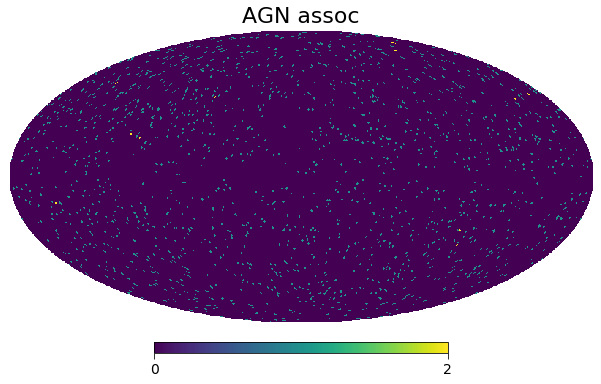

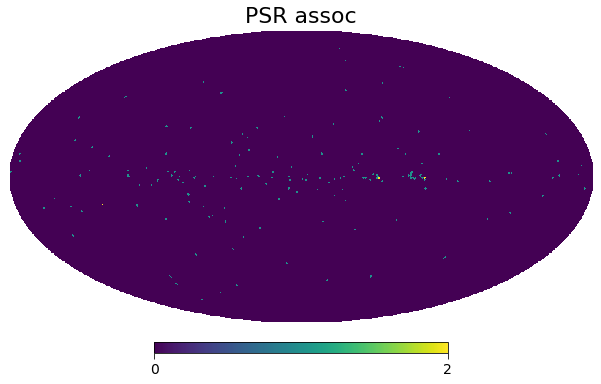

In [342]:
for pop in ['AGN', 'PSR']:
    hp.mollview(hpm_dict_ass[pop], title='%s assoc' % pop)

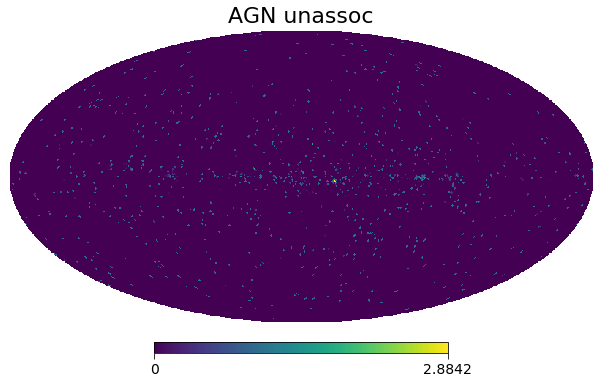

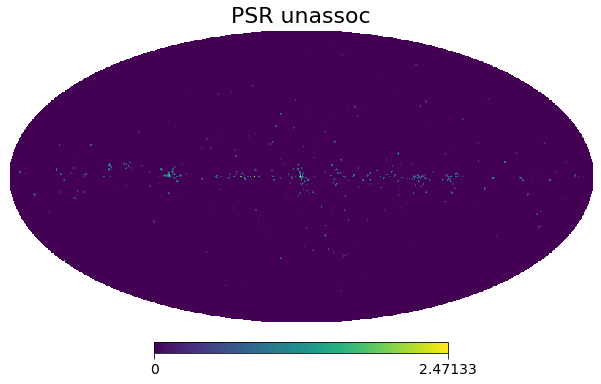

In [343]:
for pop in ['AGN', 'PSR']:
    hp.mollview(hpm_dict_unass[pop], title='%s unassoc' % pop)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


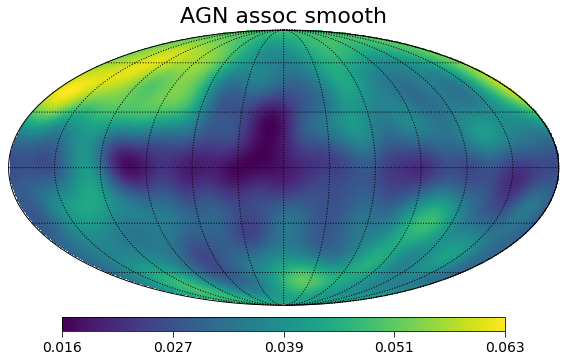

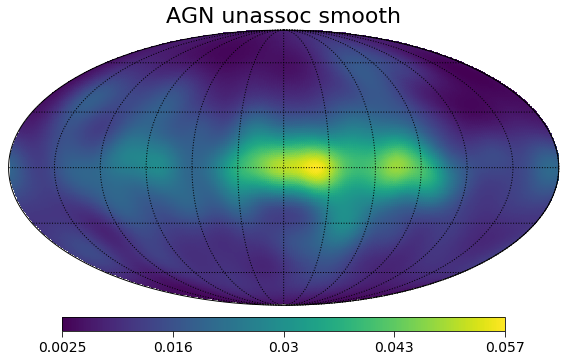

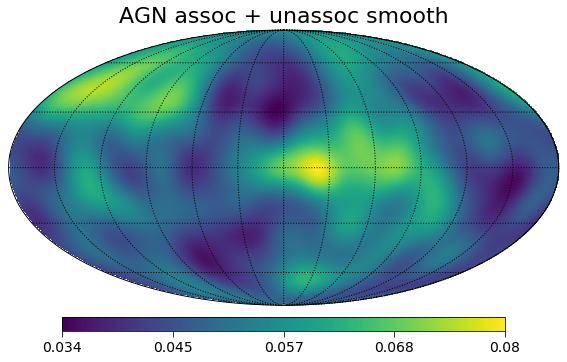

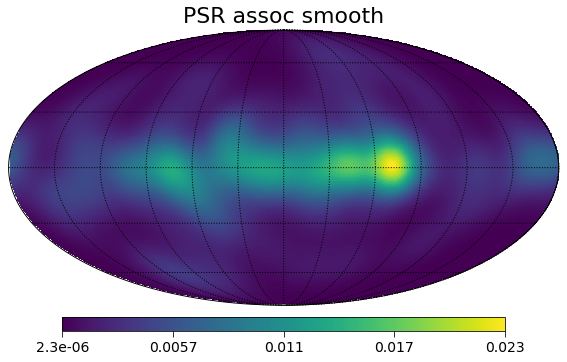

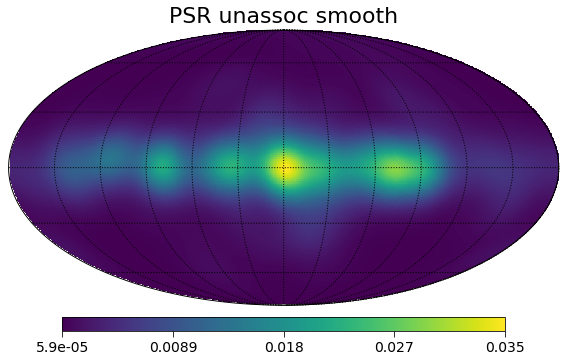

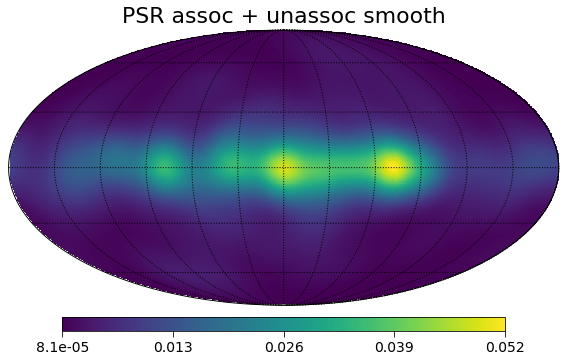

In [344]:
plot = plot_mollview # hp.mollview
nfig = 1
for pop in ['AGN', 'PSR']:
    pyplot.figure(nfig)
    plot(hpm_dict_ass[pop + '_sm'], title='%s assoc smooth' % pop, fig=nfig)
    nfig += 1
    pyplot.figure(nfig)
    plot(hpm_dict_unass[pop + '_sm'], title='%s unassoc smooth' % pop, fig=nfig)
    nfig += 1
    fig = pyplot.figure(nfig)
    hmap = hpm_dict_unass[pop + '_sm'] + hpm_dict_ass[pop + '_sm']
    plot(hmap, title='%s assoc + unassoc smooth' % pop, fig=nfig)
    fig.savefig('plots/maps/%s_assoc_unassoc.pdf' % pop)
    nfig += 1

In [345]:
# back of the envelop check of flux from pulsars for GC excess
Om = 4. * np.pi / npix # pixel area
erg2gev = 1.e3 / 1.6
sigma = np.radians(2.)
vmin = 0
vmax = 1.e-5
if cat == '3FGL':
    fn_cat = '../PS_comparison/gll_psc_v16.fit' # the last release of 3FGL
else:
    fn_cat = '../PS_comparison/gll_psc_v22.fit' # 4FGL release from 27 May 2020
fn_pcat = 'data/%s_prob_catalog.csv' % cat
hdu_cat = fits.open(fn_cat)
eflux = 'Energy_Flux100'

In [346]:
# exposure map
fn = 'data/expcube_P8_P302_Source_z100_w009_w478_P8R2_SOURCE_V6_healpix_o7_24bins.fits'
exp = fits.open(fn)
exp_data = np.array(exp[1].data.field('Spectra')).T

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


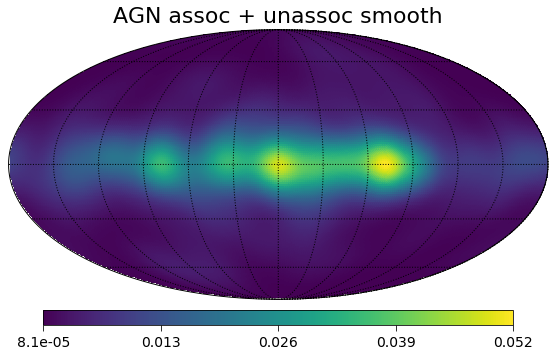

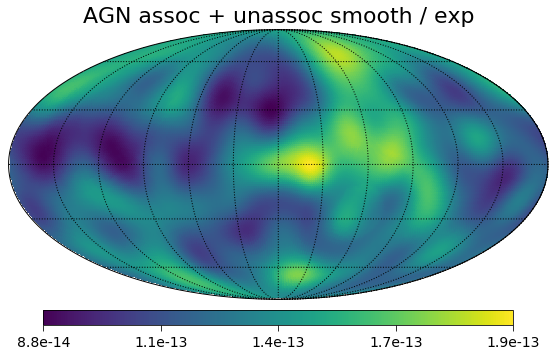

In [347]:
exp_plot = hp.ud_grade(exp_data[10], nside_out=64)
#plot(exp_plot, title='Exposure')
pop = 'AGN'
plot(hmap, title='%s assoc + unassoc smooth' % pop)
hmap = hpm_dict_unass[pop + '_sm'] + hpm_dict_ass[pop + '_sm']
plot(hmap / exp_plot, title='%s assoc + unassoc smooth / exp' % pop)


In [348]:
fgl_df0 = aux.hdu2df(hdu_cat[1], index_name='Source_Name') # transform hdu table to dataframe
fgl_df = fgl_df0.loc[cat_df.index] # remove sources with missing values

In [349]:
def make_hmap(npix, df, prob_df, mask, name, pop='PSR', method='assoc'):
    masked_df = df[mask]
    if method == 'assoc':
        weights = pd.DataFrame(data=np.ones(len(masked_df)), index=masked_df.index)
    else:
        weights=cat_df['%s_%s' % (pop, method)][mask]
    phi = np.deg2rad(df['GLON'][mask])
    theta = np.pi/2 - np.deg2rad(df['GLAT'][mask])
    pixels = hp.ang2pix(nside, theta, phi)
    hmap = np.zeros(npix)
    for ind in masked_df.index:
        hmap[pixels.loc[ind]] += fgl_df[name][ind] * weights.loc[ind]
    return hmap

In [350]:
# create a Eflux map for associated sources
name = 'Energy_Flux100'
hmap_eflux_ass_dict = {}

for pop in ['PSR', 'AGN']:
    mask = masks[pop]
    hmap = make_hmap(npix, fgl_df, cat_df, mask, name, pop=pop, method='assoc') * erg2gev / Om
    hmap_eflux_ass_dict[pop] = hmap
    hmap_eflux_ass_dict[pop + '_sm'] = hp.smoothing(hmap, sigma=sigma)

Sigma is 120.000000 arcmin (0.034907 rad) 
-> fwhm is 282.578405 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 120.000000 arcmin (0.034907 rad) 
-> fwhm is 282.578405 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


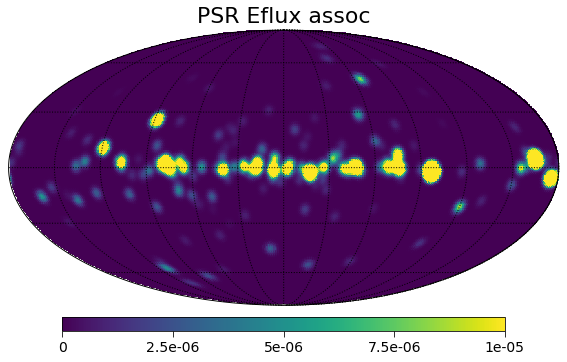

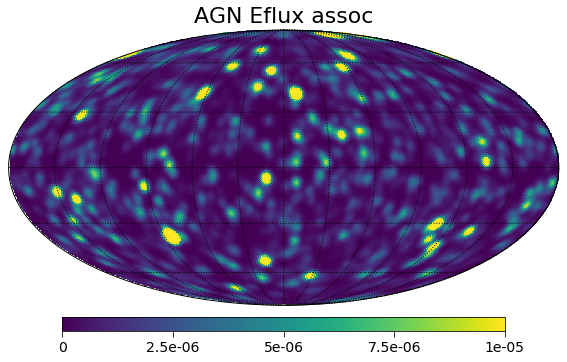

In [351]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    plot_mollview(hmap_eflux_ass_dict[pop + '_sm'], title='%s Eflux assoc' % pop, fig=nfig,
                  vmin=vmin, vmax=vmax)

In [352]:
# create a Eflux map for unassociated sources
name = 'Energy_Flux100'
hmap_eflux_unass_dict = {}

for pop in ['PSR', 'AGN']:
    mask = masks['UNAS']
    hmap = make_hmap(npix, fgl_df, cat_df, mask, name, pop=pop, method='NN') * erg2gev / Om
    hmap_eflux_unass_dict[pop] = hmap
    hmap_eflux_unass_dict[pop + '_sm'] = hp.smoothing(hmap, sigma=sigma)

Sigma is 120.000000 arcmin (0.034907 rad) 
-> fwhm is 282.578405 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 120.000000 arcmin (0.034907 rad) 
-> fwhm is 282.578405 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


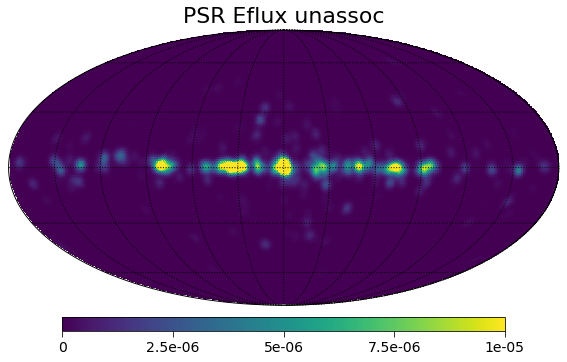

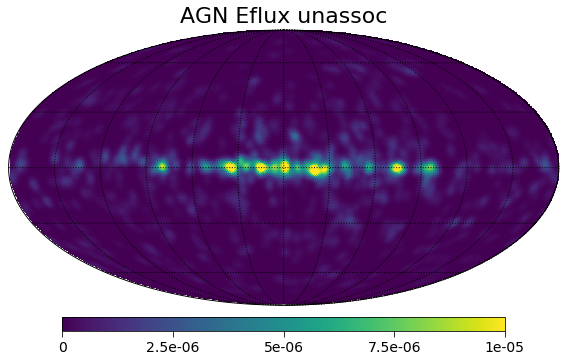

In [353]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    plot_mollview(hmap_eflux_unass_dict[pop + '_sm'], title='%s Eflux unassoc' % pop, fig=nfig,
                  vmin=vmin, vmax=vmax)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


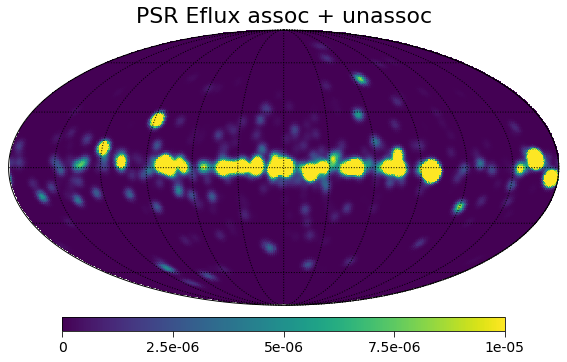

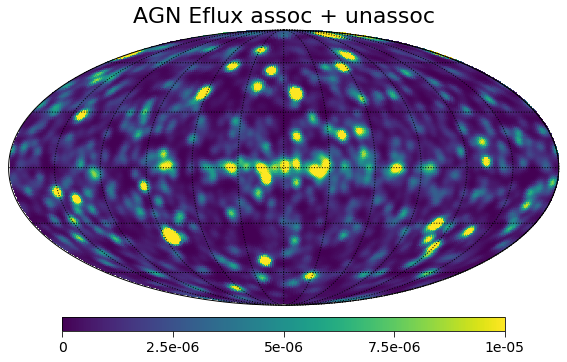

In [354]:
for nfig, pop in enumerate(['PSR', 'AGN']):
    fig = pyplot.figure(nfig)
    hmap = hmap_eflux_ass_dict[pop + '_sm'] + hmap_eflux_unass_dict[pop + '_sm']
    plot_mollview(hmap, title='%s Eflux assoc + unassoc' % pop, fig=nfig, 
                  vmin=vmin, vmax=vmax)

In [355]:
nL = 9
dL = 3.
Lbins = np.linspace(-nL * dL / 2., nL * dL / 2., nL + 1)
Lc = (Lbins[1:] + Lbins[:-1]) / 2
nB = 21
dB = 3.
Bbins = np.linspace(-nB * dB / 2., nB * dB / 2., nB + 1)
Bc = (Bbins[1:] + Bbins[:-1]) / 2

In [356]:
inds_dict = hlib.lb_profiles_hinds_dict(nside, Bbins, Lbins, mask=None)

In [357]:
fpix = hmap_eflux_unass_dict['PSR']
profiles = hlib.fpix_lb_profiles(fpix, inds_dict, nB, nL, std=0)

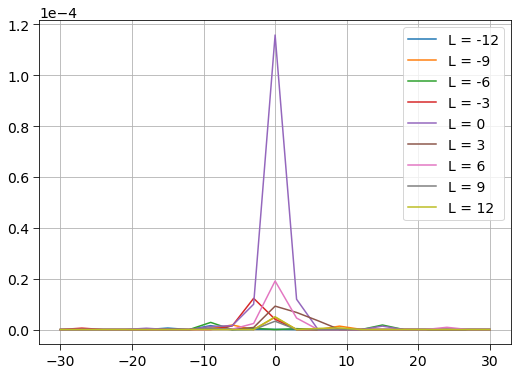

In [358]:
# latitude profiles
fig = pyplot.figure()
for i in range(nL):
    ys = profiles[:, i]
    pyplot.plot(Bc, ys, label='L = %i' % Lc[i])
pyplot.legend()
fig.axes[0].ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
pyplot.grid()

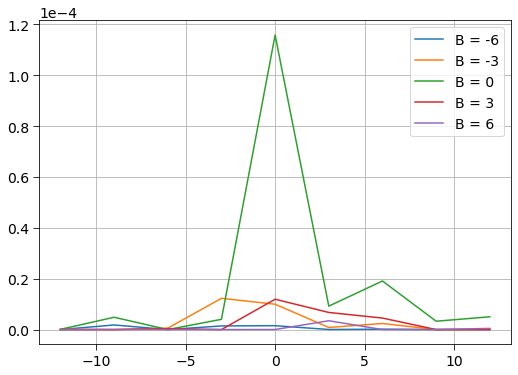

In [359]:
# longitude profiles
fig = pyplot.figure()
for i in range(8, 13):
    ys = profiles[i]
    pyplot.plot(Lc, ys, label='B = %i' % Bc[i])
fig.axes[0].ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
pyplot.legend()
pyplot.grid()

In [360]:
thres = 0.5
ang = 20
bl_mask = (cat_df['GLON'] < ang) | (cat_df['GLON'] > 360 - ang)
print(np.sum(bl_mask))
bl_mask &= (cat_df['GLAT'] < ang) & (cat_df['GLAT'] > - ang)
print(np.sum(bl_mask))
bl_mask &= masks['UNAS']
print('Number of unassociated sources: %i' % np.sum(bl_mask))
bl_mask_thres = bl_mask & (cat_df['PSR_NN'] > thres)
print('%i sources above threshold %.1f' % (np.sum(bl_mask_thres), thres))
print('Sum of probabilities: %.1f' % np.sum(cat_df['PSR_NN'][bl_mask]))

367
201
Number of unassociated sources: 111
33 sources above threshold 0.5
Sum of probabilities: 38.4


In [361]:
min_psr_eflux = np.min(fgl_df[eflux][bl_mask])

In [362]:
kpc2sm = 3.e21 # kpc in cm
def eflux2elum(eflux, dist):
    dist_cm = dist * kpc2sm
    return 4. * np.pi * eflux * dist_cm**2

In [363]:
Elums = eflux2elum(fgl_df[eflux][bl_mask], 8.5)

(array([ 2.,  3.,  6.,  6., 11.,  9.,  9., 12., 13., 12.,  9.,  7.,  3.,
         1.,  3.,  3.,  0.,  1.,  0.,  1.]),
 array([34.44723005, 34.53864534, 34.63006064, 34.72147593, 34.81289122,
        34.90430651, 34.99572181, 35.0871371 , 35.17855239, 35.26996769,
        35.36138298, 35.45279827, 35.54421356, 35.63562886, 35.72704415,
        35.81845944, 35.90987474, 36.00129003, 36.09270532, 36.18412062,
        36.27553591]),
 <a list of 20 Patch objects>)

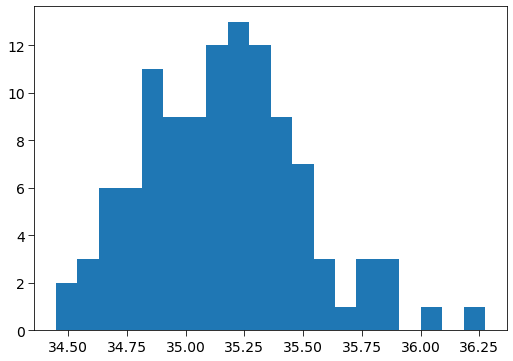

In [364]:
pyplot.hist(np.log10(Elums), bins=20)

In [365]:
pcat_SP

,Unnamed: 0,Signif,Flux,RA,DEC,GLON,GLAT,ASSOC1,CLASS1,LR_P,LR_Pred,RF_P,RF_Pred,PSR_Out,AGN_Out,BLR_PSR_P,BLR_PSR_Pred,RF_PSR_P,RF_PSR_Pred
3FGL J0000.1+6545,1,6.813,1.010000e-12,0.038,65.7517,117.69,3.4030,,NaN,0.378,PSR,0.186,PSR,203.048,10.789,0.219,MSP,0.520,YNG
3FGL J0000.2-3738,2,5.091,1.940000e-14,0.061,-37.6484,345.41,-74.9468,,NaN,0.001,AGN,0.000,AGN,109.487,-0.633,0.000,NaN,0.128,NaN
3FGL J0001.0+6314,3,6.164,8.620000e-12,0.254,63.2440,117.29,0.9257,,spp,0.004,AGN,0.054,AGN,187.325,4.199,0.160,NaN,0.406,NaN
3FGL J0001.2-0748,4,11.253,4.850000e-13,0.321,-7.8159,89.02,-67.3242,PMN J0001-0746,bll,0.019,AGN,0.014,AGN,81.144,2.637,0.001,NaN,0.038,NaN
3FGL J0001.4+2120,5,11.350,2.520000e-11,0.361,21.3379,107.67,-40.0472,TXS 2358+209,fsrq,0.000,AGN,0.004,AGN,203.170,1.546,0.008,NaN,0.322,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3FGL J2358.5+3827,3017,5.892,4.810000e-14,359.634,38.4539,111.69,-23.2600,,NaN,0.000,AGN,0.000,AGN,121.365,-0.654,0.000,NaN,0.148,NaN
3FGL J2358.6-1809,3018,6.513,2.100000e-14,359.666,-18.1585,66.60,-74.8950,,NaN,0.001,AGN,0.002,AGN,126.071,-0.694,0.000,NaN,0.112,NaN
3FGL J2358.9+3926,3019,4.685,7.460000e-14,359.736,39.4476,112.01,-22.3080,B2 2356+39,fsrq,0.000,AGN,0.002,AGN,159.345,0.661,0.008,NaN,0.176,NaN
3FGL J2359.3-3038,3020,11.055,1.200000e-13,359.829,-30.6465,12.71,-78.0699,H 2356-309,bll,0.001,AGN,0.000,AGN,119.240,-0.714,0.001,NaN,0.118,NaN


UNAS
905 1008
SP: 217.912
we: 183.51571106400002
AGN & PSR
1172 1905
SP: 156.94
we: 146.01776756900003
UNAS
709 1008
SP:

/Users/Dmitry/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 264.711
we: 189.670910111
AGN & PSR
758 1905
SP: 90.27999999999999
we: 83.91083474700001


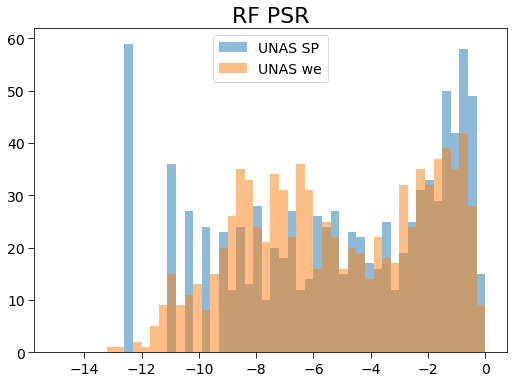

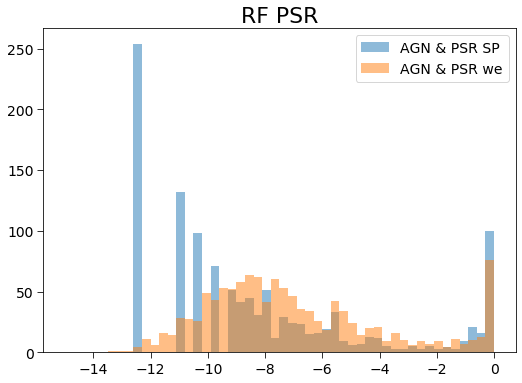

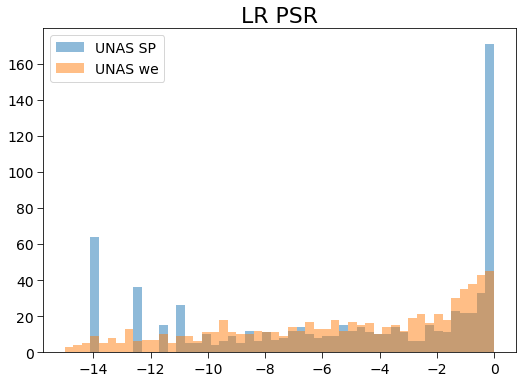

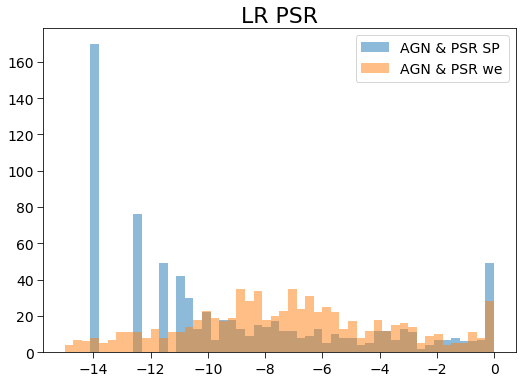

In [366]:
vmin = -15.
vmax = 0.
for alg in ['RF', 'LR']:
    for pop in ['UNAS', 'AGN & PSR']:
        pyplot.figure()
        print(pop)
        vals_SP = 2 * np.log(pcat_SP['%s_P' % alg][masks[pop]])
        vals_we = 2 * np.log(cat_df['PSR_%s' % alg][masks[pop]])
        mask = (vals_SP < vmax) & (vals_SP > vmin) & (vals_we < vmax) & (vals_we > vmin)
        print(sum(mask), len(mask))
        print('SP:', np.sum(pcat_SP['%s_P' % alg][masks[pop] & mask]))
        print('we:', np.sum(cat_df['PSR_%s' % alg][masks[pop] & mask]))
        hst = pyplot.hist(vals_SP[mask], bins=np.linspace(vmin, vmax, 51), alpha = 0.5, 
                          label=pop + ' SP')
        hst = pyplot.hist(vals_we[mask], bins=np.linspace(vmin, vmax, 51), alpha = 0.5, 
                          label=pop + ' we')
        pyplot.legend()
        pyplot.title(alg + ' PSR')

In [367]:
masks.keys()

dict_keys(['AGN & PSR', 'AGN', 'PSR', 'UNAS', 'ASSOC'])